# Kaggle Titanic Spaceship Competition

## Overview

In [ ]:
This competition is a kaggle competition submission, competition can be found here. This is the first EDA notebook. Here I will inspect the data to find trends and then complete some basic data cleaning steps.

1. Importing - Import dataset as pandas dataframe and import any required packages
2. Data dictionary notes - Take notes on each of the columns
3. Data Exploration - Using Pandas profiling and making notes on findings
2. Data cleaning and processing
3. Creating a function which cleans the data end-to-end

## Importing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import pandas_profiling

In [2]:
df_test = pd.read_csv("../data/raw/test.csv")
df_train = pd.read_csv("../data/raw/train.csv")
df_sample = pd.read_csv("../data/raw/sample_submission.csv")

## Data Overview

Here we take each of the columns and look at all of the values using pandas to determine some of it's properties, then we brainstorm ideas for feature engineering.

In [3]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [4]:
df_train.shape

(8693, 14)

In [5]:
df_train.head(5)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

## EDA Round 1
This round of EDA examines the data dictionary and gives names to each of the colummns. We will run a pandas profiler to examine the columns and make notes on them. Then we will do some preliminary data cleaning.

In [14]:
df_train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- PassengerId 
    1. This is a unique identifier for each passenger
    2. gggg_pp; g = group, p = passenger number. Could be used to create a group size/family feature
    3. evey value is unique
    4. window function and sum for group to find the total number of people in each group
 - HomePlanet
    1. The planet they departed from, typically their planet of permenant residence
    2. Highly correlated with destination
    3. 2.3% missing values. Can impute with the groups home planet?

- Cryosleep - 
    1. Highly correlated with target variable
    2. Cryosleep means they were in their cabin so this is important
    3. 2.3% missing values will have to investigate this

- Cabin
    1. Data cleaning needed
    2. Impute missing values based on family indicator
    3. Likely will have to do one-hot encoding

- Age
    1. Impute with mean
    2. Could cluster people and put in mean that way

- VIP
    1. Very few VIP so will impute with false

- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck. 
    1. This is the total money spent. This would likely be highly correlated with VIP.
    2. Many missing values, very likely just 0 so impute with 0.
    

- Name
    1. Probbaly not correlation although we may be able to deduce family from this
   

## Data Cleaning

Now we need to create some additional features and clean the data. Below is a list of cleaning steps required.

1. Split passengerId into group and person
2. Calculate the number of people within each group and add that as a categorical feature as group size
3. Impute HomePlanet values
4. Find within cabin and within group versions of cryosleep
5. Impute age with mean
6. Impute VIP with false
7. Impute missing values for numeric columns with 0
8. Drop name columns

In [63]:
def CleaningPipeline(df):
    
    df = df.assign(
                #1. Split passengerId into group and person
                group = lambda x: x['PassengerId'].str.split('_',expand = True).iloc[:,0],

                #2. Calculate the number of people within each group and add that as a categorical feature as group size
                group_size = lambda x: x.groupby('group')['group'].transform('count'),

                #3. Impute HomePlanet and destination with most common values
                Homeplanet = lambda x: x['HomePlanet'].fillna('Missing'),
                Destination = lambda x: x['Destination'].fillna('Missing'),
        
                #4. Find cabin type
                deck = lambda x: x['Cabin'].str.split('/',expand = True).iloc[:,0],
                side = lambda x: x['Cabin'].str.split('/',expand = True).iloc[:,2],
                section = lambda x: (x['deck'] + x['side']).fillna('Missing'),

                #5. Impute age with mean
                Age = lambda x: x['Age'].fillna(x['Age'].mean()),

                #6. Impute VIP with false
                VIP = lambda x: x['VIP'].fillna(False),

                #7. Impute missing values for numeric columns with 0
                RoomService = lambda x: x['RoomService'].fillna(0),
                FoodCourt = lambda x: x['RoomService'].fillna(0),
                ShoppingMall = lambda x: x['RoomService'].fillna(0),
                Spa = lambda x: x['RoomService'].fillna(0),
                VRDeck = lambda x: x['RoomService'].fillna(0),

                # 8. Impute cryosleep missing values with false
                CryoSleep = lambda x: x['CryoSleep'].fillna(False),
                
                # 9. Drop name columns
            ).drop(['Cabin', 'Name', 'deck','side','HomePlanet','PassengerId','group'], axis = 1)
    
    


    return df

train_ct_df = CleaningPipeline(df_train)


In [64]:
train_ct_df.isna().any()

CryoSleep       False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Transported     False
group_size      False
Homeplanet      False
section         False
dtype: bool

## EDA Round 2

In [66]:
df_sample = train_ct_df.sample(frac=0.4)
df_sample.reset_index(drop=True, inplace=True)


profile = df_sample.profile_report(
    title="Report without correlations",
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    }
)

profile.to_file("../reports/Pandas_Profiling_Second_EDA_01.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
profile.to_notebook_iframe()


### Notes from EDA 2

1. All numeric columns are highly correlated, could replace this with a single money spent column
2. Cryosleep is highly correlated with transported, therefore we could try hard to predict the missing cryo people
3. Homeplanet is highly correlated with section, therefore could likely impute section from homeplanet
4. Age has a lot of zeros, probably a data quality issue

In [74]:
df_train['total_spent'] = df_train['RoomService'] +  df_train['FoodCourt'] +  df_train['Spa'] +  df_train['VRDeck'] +  df_train['ShoppingMall']

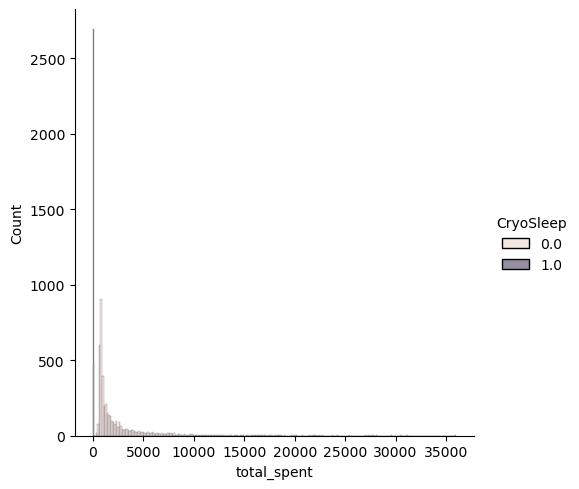

In [82]:
sns.displot(data=df_train,x='total_spent',hue = 'CryoSleep')

In [91]:
df_train[df_train['CryoSleep']==False].count()

PassengerId     5439
HomePlanet      5315
CryoSleep       5439
Cabin           5331
Destination     5309
Age             5343
VIP             5318
RoomService     5328
FoodCourt       5329
ShoppingMall    5335
Spa             5326
VRDeck          5320
Name            5311
Transported     5439
total_spent     4902
dtype: int64

In [ ]:
def CleaningPipeline(df):
    
    df = df.assign(
                #1. Split passengerId into group and person
                group = lambda x: x['PassengerId'].str.split('_',expand = True).iloc[:,0],

                #2. Calculate the number of people within each group and add that as a categorical feature as group size
                group_size = lambda x: x.groupby('group')['group'].transform('count'),

                #3. Impute HomePlanet and destination with most common values
                Homeplanet = lambda x: x['HomePlanet'].fillna('Missing'),
                Destination = lambda x: x['Destination'].fillna('Missing'),
        
                #4. Find cabin type
                deck = lambda x: x['Cabin'].str.split('/',expand = True).iloc[:,0],
                side = lambda x: x['Cabin'].str.split('/',expand = True).iloc[:,2],
                section = lambda x: (x['deck'] + x['side']).fillna('Missing'),

                #5. Impute age with mean
                Age = lambda x: x['Age'].fillna(x['Age'].mean()),

                #6. Impute VIP with false
                VIP = lambda x: x['VIP'].fillna(False),

                #7. Impute missing values for numeric columns with 0
                RoomService = lambda x: x['RoomService'].fillna(0),
                FoodCourt = lambda x: x['RoomService'].fillna(0),
                ShoppingMall = lambda x: x['RoomService'].fillna(0),
                Spa = lambda x: x['RoomService'].fillna(0),
                VRDeck = lambda x: x['RoomService'].fillna(0),

                # 8. Impute cryosleep missing values with false
                CryoSleep = lambda x: x['CryoSleep'].fillna(False),
                
                # 9. Drop name columns
            ).drop(['Cabin', 'Name', 'deck','side','HomePlanet','PassengerId','group'], axis = 1)
    
    


    return df

train_ct_df = CleaningPipeline(df_train)